In [111]:
pip install pmdarima

In [112]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error

In [114]:
def normalise(df):
  scaler = StandardScaler()
  df[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(df[['Emission', 'Fertlizer_consumption', 'Temperature']])
  return df

def train_test_split(df, country):
  country_df = df[df['Country']==country].drop(columns=['Cluster', 'Country'])
  country_df.set_index('Year', inplace=True)
  train_size = int(len(country_df)*0.5)
  xtrain, xtest = country_df[:train_size], country_df[train_size:]
  return xtrain, xtest

def auto_model(xtrain):
  optimal_model = auto_arima(xtrain['Emission'],
                        exogenous= xtrain[['Fertlizer_consumption', 'Temperature']],
                        seasonal=False,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  return optimal_model

def sarimax_model (xtrain, order, seasonal_order):
  sarimax_model = SARIMAX(xtrain['Emission'],
                        exog=xtrain[['Fertlizer_consumption', 'Temperature']],
                        order = order,
                        seasonal_order = seasonal_order)
  return sarimax_model

In [115]:
cluster_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/clustered_forecast_data.xlsx').drop(columns=['Unnamed: 0'])

In [116]:
print(cluster_df.head())

        Year      Country   Emission  Fertlizer_consumption  Temperature  \
0 1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1 1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2 1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3 1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4 1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [117]:
norm_cluster_df = cluster_df.groupby('Country').apply(lambda x : normalise(x)).reset_index(drop=True)

In [118]:
country_list = ['China', 'United States']

In [119]:
for country in country_list:
  country_df = norm_cluster_df[norm_cluster_df['Country']==country]
  country_df = country_df.drop(columns=['Country', 'Cluster'])
  country_df.set_index('Year', inplace=True)
  print(country)
  for col in country_df.columns:
    result = adfuller(country_df[col])
    print('p-value:', result[1])

China
p-value: 0.43705876632596735
p-value: 0.35910852814346617
p-value: 0.9830421590144939
United States
p-value: 0.0001300030999971101
p-value: 0.027588015851473968
p-value: 0.8604558151280162


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-76.581, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-81.755, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-79.823, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-79.913, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.988, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.652 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


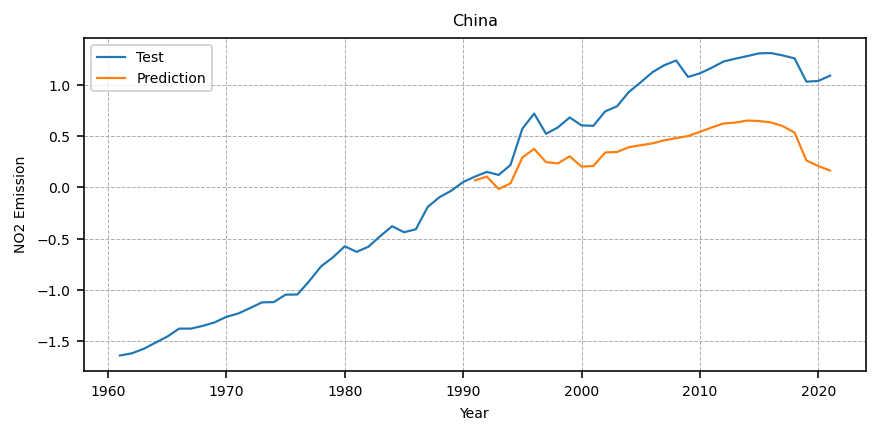

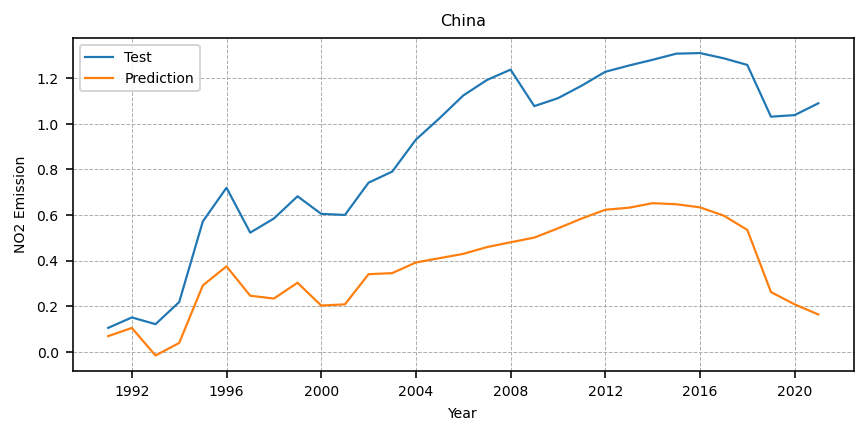

RMSE :  0.5594077695219328
MAPE :  0.5890808796591636
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=105.974, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42.918, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=78.558, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=39.301, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=38.739, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=38.339, Time=0.20 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=40.105, Time=0.24 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=40.567, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=42.233, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=39.765, Time=0.43 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 3.694 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


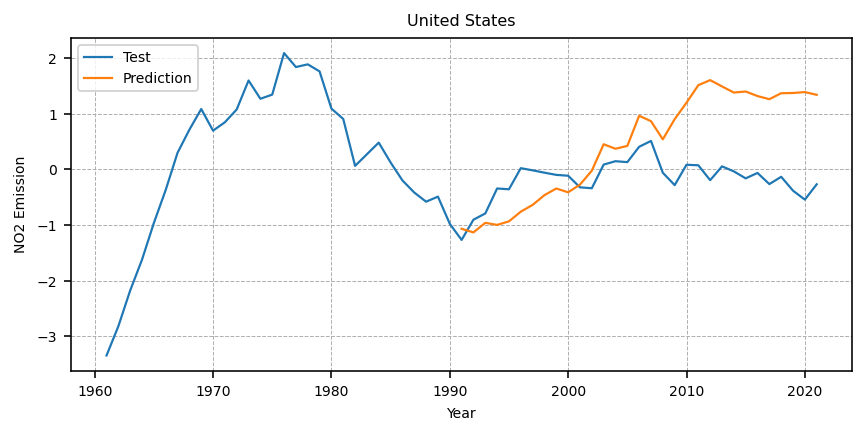

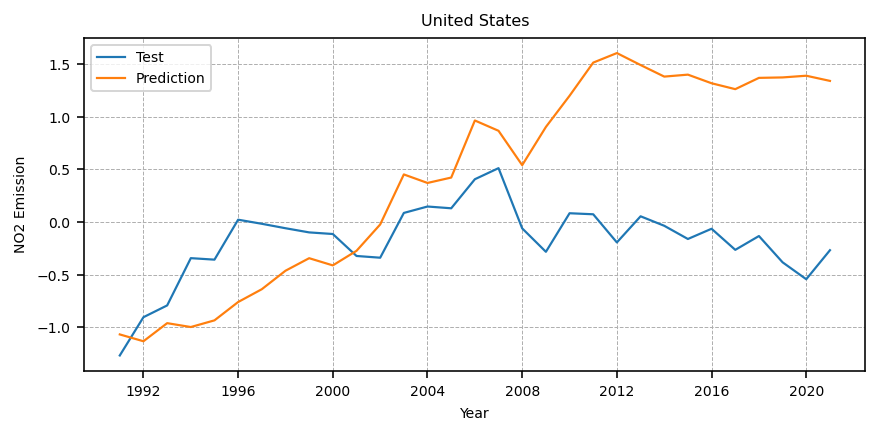

RMSE :  1.0433494365028964
MAPE :  9.170794320019194


In [120]:
for country in country_list:

  xtrain,xtest = train_test_split(norm_cluster_df, country)

  country_df = norm_cluster_df[norm_cluster_df['Country']==country]

  optimal_model = auto_model(xtrain)

  order = optimal_model.order
  seasonal_order = optimal_model.seasonal_order

  model = sarimax_model(xtrain, order, seasonal_order)
  model_fit = model.fit()

  prediction = model_fit.forecast(steps=len(xtest),
                             exog=xtest[['Fertlizer_consumption', 'Temperature']])

  plt.figure(dpi=144, figsize=(7,3))
  plt.plot(country_df['Year'], country_df['Emission'], label="Test",
            linewidth = 1.1)
  plt.plot(xtest.index, prediction, label='Prediction',
          linewidth = 1.1)
  plt.xlabel("Year", fontsize=7)
  plt.ylabel("NO2 Emission", fontsize=7)
  plt.grid(linewidth=0.5, linestyle='--')
  plt.legend(fontsize=7)
  plt.xticks(fontsize=7)
  plt.yticks(fontsize=7)
  plt.title(country, fontsize=8)
  plt.show()

  plt.figure(dpi=144, figsize=(7,3))
  plt.plot(xtest.index, xtest['Emission'], label="Test",
            linewidth = 1.1)
  plt.plot(xtest.index, prediction, label='Prediction',
          linewidth = 1.1)
  plt.xlabel("Year", fontsize=7)
  plt.ylabel("NO2 Emission", fontsize=7)
  plt.grid(linewidth=0.5, linestyle='--')
  plt.legend(fontsize=7)
  plt.xticks(fontsize=7)
  plt.yticks(fontsize=7)
  plt.title(country, fontsize=8)
  plt.show()

  mse = mean_squared_error(xtest['Emission'], prediction)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(xtest['Emission'], prediction)
  print("RMSE : ",rmse)
  print("MAPE : ",mape)